In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from IPython import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np


In [38]:
device = torch.device("mps")

In [3]:
df = pd.read_csv('../data/30_yr_stock_market_data.csv')


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [5]:
print(df.columns.tolist())


['Dow Jones (^DJI)', 'Nasdaq (^IXIC)', 'S&P500 (^GSPC)', 'NYSE Composite (^NYA)', 'Russell 2000 (^RUT)', 'CBOE Volitility (^VIX)', 'DAX Index (^GDAXI)', 'FTSE 100 (^FTSE)', 'Hang Seng Index (^HSI)', 'Cocoa (CC=F)', 'Coffee (KC=F)', 'Corn (ZC=F)', 'Cotton (CT=F)', 'Live Cattle (LE=F)', 'Orange Juice (OJ=F)', 'Soybeans (ZS=F)', 'Sugar (SB=F)', 'Wheat (ZW=F)', 'Ethanol (EH=F)', 'Heating Oil (HO=F)', 'Natural Gas (NG=F)', 'Crude Oil-Brent (BZ=F)', 'Crude Oil-WTI (CL=F)', 'Copper (HG=F)', 'Gold (GC=F)', 'Palladium (PA=F)', 'Platinum (PL=F)', 'Silver (SI=F)', 'Treasury Yield 5 Years (^FVX)', 'Treasury Bill 13 Week (^IRX)', 'Treasury Yield 10 Years (^TNX)', 'Treasury Yield 30 Years (^TYX)']


In [25]:
dow_jones = df["Dow Jones (^DJI)"]
# Forward fill the missing values
dow_jones = dow_jones.ffill()

# Optionally, you can also backfill any remaining NaNs
dow_jones = dow_jones.bfill()


In [26]:
print(dow_jones.describe())



count     7754.000000
mean     14881.339203
std       8515.834197
min       3593.350098
25%       9474.327393
50%      11341.364746
75%      18084.122070
max      36799.648438
Name: Dow Jones (^DJI), dtype: float64


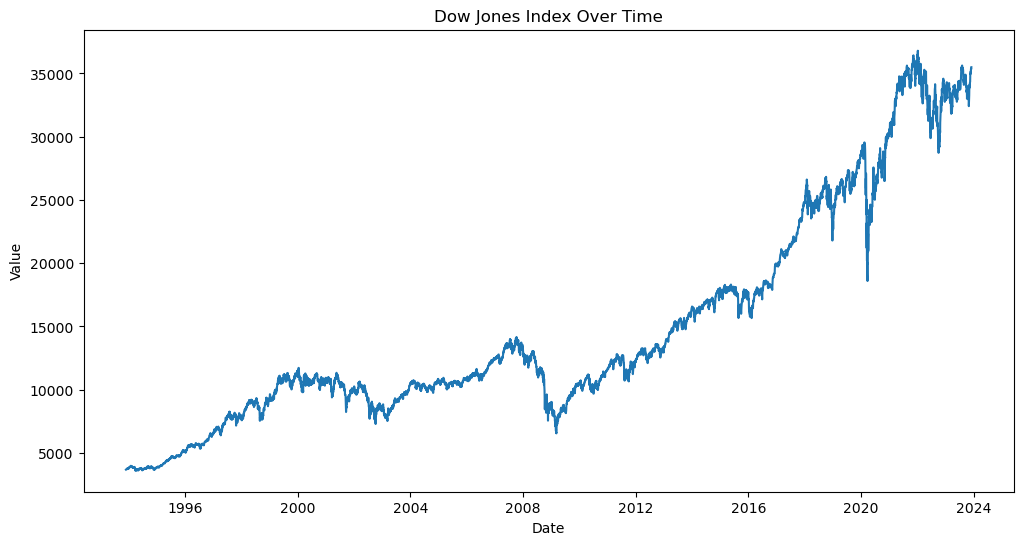

In [27]:
plt.figure(figsize=(12,6))
plt.plot(dow_jones)
plt.title('Dow Jones Index Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


In [28]:
# Reshape data for scaling
dow_jones_values = dow_jones.values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dow_jones_values)


In [29]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

# Choose a sequence length
seq_length = 10  # This is a hyperparameter you can tune

# Create sequences
X, y = create_sequences(scaled_data, seq_length)


In [30]:
X[:5],y[:5]

(array([[[0.00254319],
         [0.00272839],
         [0.0031238 ],
         [0.00327528],
         [0.00333431],
         [0.00351921],
         [0.0037803 ],
         [0.0042516 ],
         [0.00410856],
         [0.0044365 ]],
 
        [[0.00272839],
         [0.0031238 ],
         [0.00327528],
         [0.00333431],
         [0.00351921],
         [0.0037803 ],
         [0.0042516 ],
         [0.00410856],
         [0.0044365 ],
         [0.00515203]],
 
        [[0.0031238 ],
         [0.00327528],
         [0.00333431],
         [0.00351921],
         [0.0037803 ],
         [0.0042516 ],
         [0.00410856],
         [0.0044365 ],
         [0.00515203],
         [0.00449553]],
 
        [[0.00327528],
         [0.00333431],
         [0.00351921],
         [0.0037803 ],
         [0.0042516 ],
         [0.00410856],
         [0.0044365 ],
         [0.00515203],
         [0.00449553],
         [0.00372128]],
 
        [[0.00333431],
         [0.00351921],
         [0.0037803 ],

In [31]:
# Define split sizes
train_size = int(len(X) * 0.7)
validation_size = int(len(X) * 0.15)

# Split the data
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + validation_size], y[train_size:train_size + validation_size]
X_test, y_test = X[train_size + validation_size:], y[train_size + validation_size:]



In [32]:
# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_val, y_val = torch.tensor(X_val).float(), torch.tensor(y_val).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()


In [100]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

        # Add a dictionary to store activations
        self.activations = {}

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        self.activations['lstm'] = lstm_out.detach().cpu().numpy()

        predictions = self.linear(lstm_out[:, -1, :])
        self.activations['linear'] = predictions.detach().cpu().numpy()
        return predictions

model = SimpleLSTM()
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [101]:
parameter_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(parameter_count)


41301


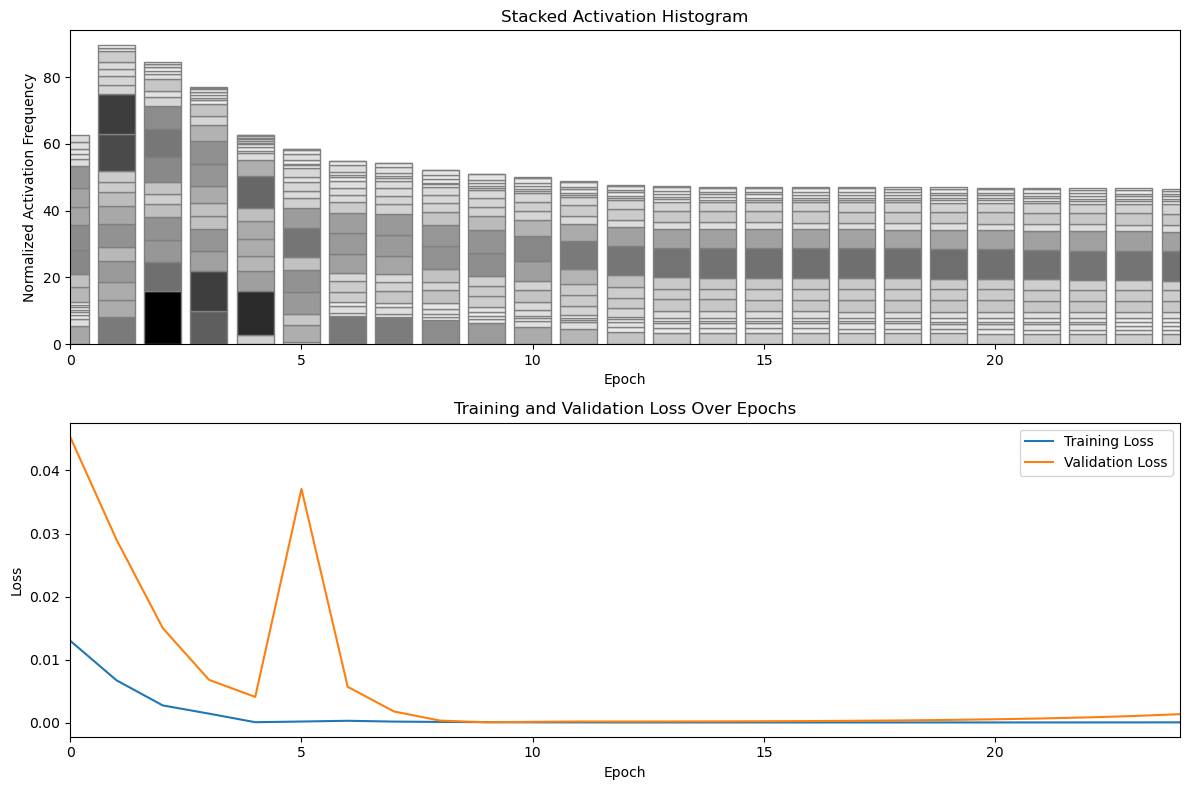

Epoch 25/25, Training Loss: 0.0001, Validation Loss: 0.0014


In [102]:
# Training settings
epochs = 25
batch_size = 64  # You can adjust this based on your dataset size and memory constraints

# Function to create mini-batches
def get_batches(X, y, batch_size):
    for i in range(0, len(X), batch_size):
        X_batch = X[i:i + batch_size].to(device)
        y_batch = y[i:i + batch_size].to(device)
        yield X_batch, y_batch
        

# Lists to store losses for plotting
train_losses = []
val_losses = []

# Define the number of bins for the histogram
num_bins = 20


# Initialize a data structure to store activations for each epoch
# This will be a list of lists, with each inner list containing the binned activation counts for an epoch
activation_histograms = []

# Training loop
for epoch in range(epochs):
    # Temporary list to store activations for the epoch
    epoch_activations = []

    for X_batch, y_batch in get_batches(X_train, y_train, batch_size):
        # Move batch to device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Store LSTM activations
        lstm_activations = outputs.detach().cpu().numpy().flatten()
        epoch_activations.append(np.abs(lstm_activations))

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    # Store the losses
    train_losses.append(loss.item())
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val.to(device))
        val_loss = criterion(val_predictions, y_val.to(device))
    val_losses.append(val_loss.item())
    model.train()

    # Process activations to compute the histogram for the current epoch
    activations = np.hstack(epoch_activations)
    # Normalize the histogram to represent frequency
    counts, _ = np.histogram(activations, bins=num_bins, density=True)
    activation_histograms.append(counts)

    # Clear the current figure
    display.clear_output(wait=True)

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))

    # Activation histogram (stacked)
    # Convert the list of histograms into a 2D NumPy array for easier plotting
    hist_array = np.array(activation_histograms)
    # Calculate the maximum count to normalize the color scale
    max_count = hist_array.max()

    # Plot the stacked histogram using greyscale colors
    for bin_idx in range(num_bins):
        normalized_counts = hist_array[:, bin_idx] / max_count
        colors = 1.0 - normalized_counts  # Invert colors: high frequency -> white, low frequency -> black
        axs[0].bar(range(epoch + 1), hist_array[:, bin_idx], bottom=np.sum(hist_array[:, :bin_idx], axis=1),
                   color=[f'{c}' for c in colors], edgecolor='grey')


    axs[0].set_title(f'Stacked Activation Histogram')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Normalized Activation Frequency')
    axs[0].set_xlim(0, epochs - 1)  # Limit x-axis to the number of epochs

    # Loss plot
    axs[1].plot(train_losses, label='Training Loss')
    axs[1].plot(val_losses, label='Validation Loss')
    axs[1].set_title('Training and Validation Loss Over Epochs')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xlim(0, epochs - 1)  # Limit x-axis to the number of epochs
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')




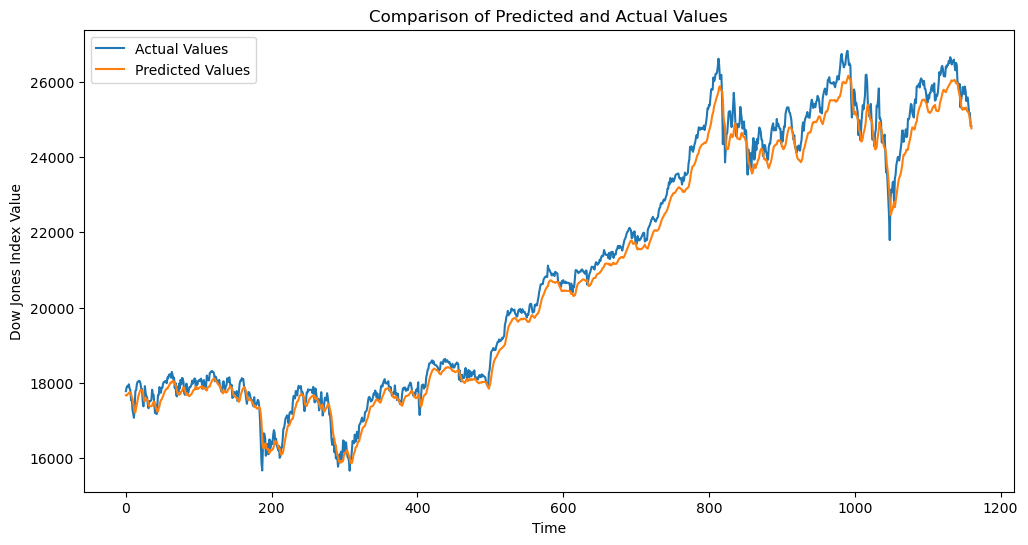

In [94]:
# Assuming you have a list/array of predictions and actuals for the validation set
val_predictions = model(X_val.to(device)).cpu().detach().numpy()
val_actuals = y_val.cpu().numpy()

# Inverse transform these values
val_predictions_inverse = scaler.inverse_transform(val_predictions)
val_actuals_inverse = scaler.inverse_transform(val_actuals)

# Plotting
plt.figure(figsize=(12,6))
plt.plot(val_actuals_inverse, label='Actual Values')
plt.plot(val_predictions_inverse, label='Predicted Values')
plt.title('Comparison of Predicted and Actual Values')
plt.xlabel('Time')
plt.ylabel('Dow Jones Index Value')
plt.legend()
plt.show()


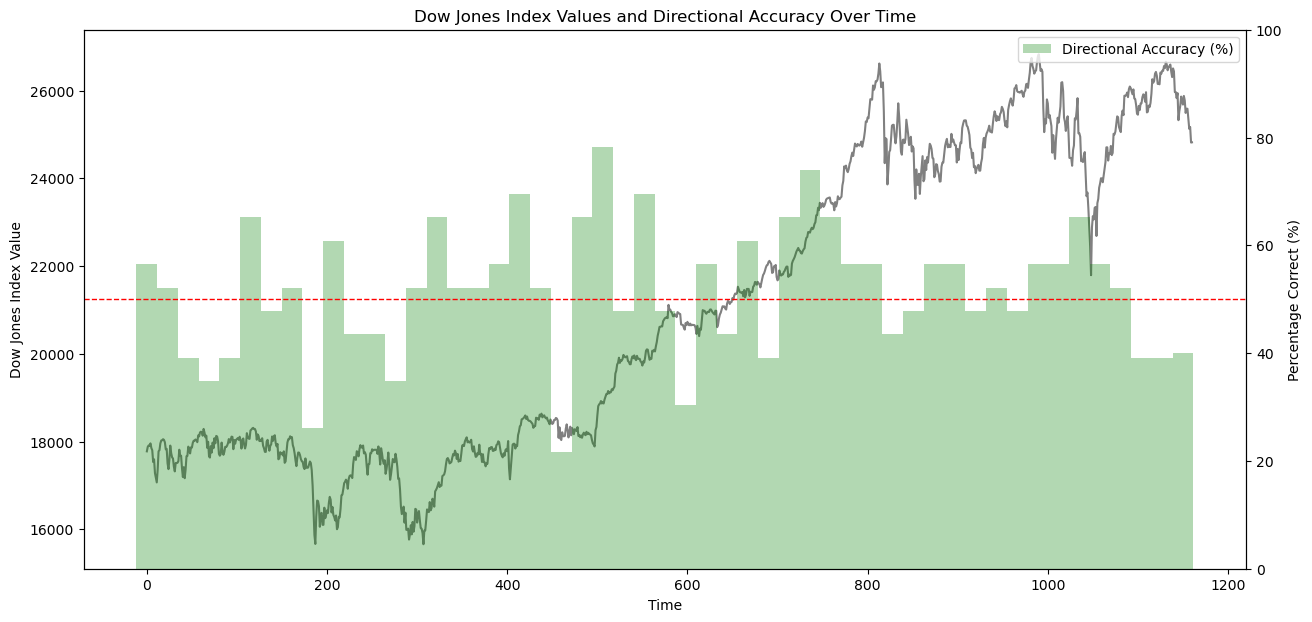

In [95]:
actual_changes = np.diff(val_actuals_inverse.flatten()) >= 0
predicted_changes = np.diff(val_predictions_inverse.flatten()) >= 0

correct_direction = actual_changes == predicted_changes

# Number of bins
num_bins = 50

# Calculate the length of each bin
bin_length = len(correct_direction) // num_bins

# Plot the actual values
plt.figure(figsize=(15, 7))
plt.plot(val_actuals_inverse.flatten(), label='Actual Values', color='gray')
plt.xlabel('Time')
plt.ylabel('Dow Jones Index Value')

# Create a secondary y-axis for percentages
ax2 = plt.twinx()

# Calculate the percentage of correct predictions for each bin
bin_percentages = []
for i in range(0, len(correct_direction), bin_length):
    bin_correct = correct_direction[i:i + bin_length]
    bin_percentage = np.sum(bin_correct) / len(bin_correct) * 100
    bin_percentages.append(bin_percentage)

# Plot the bin percentages
ax2.bar(range(0, len(correct_direction), bin_length), bin_percentages, 
        width=bin_length, alpha=0.3, color='green', label='Directional Accuracy (%)')
ax2.set_ylabel('Percentage Correct (%)')
ax2.set_ylim(0, 100)  # Set y-axis limits for percentages
ax2.axhline(50, color='red', linestyle='--', linewidth=1)

# Add legend
plt.title('Dow Jones Index Values and Directional Accuracy Over Time')
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [96]:
def rolling_mean_prediction(data, window_size):
    """
    Calculate rolling mean predictions.
    
    :param data: Input data (numpy array).
    :param window_size: Window size for rolling mean.
    :return: Predictions as a numpy array.
    """
    predictions = np.zeros(len(data) - window_size)

    for i in range(len(data) - window_size):
        predictions[i] = np.mean(data[i:i + window_size])

    return predictions

# Assuming your sequence length is 10
window_size = 10

# Apply the rolling mean model to the validation data
# Note: You need to inverse transform your normalized data first
val_data_inverse = scaler.inverse_transform(X_val.view(-1, 1).numpy())
val_data_inverse = val_data_inverse.reshape(X_val.shape[0], X_val.shape[1])

rolling_predictions = rolling_mean_prediction(val_data_inverse[:, 0], window_size)



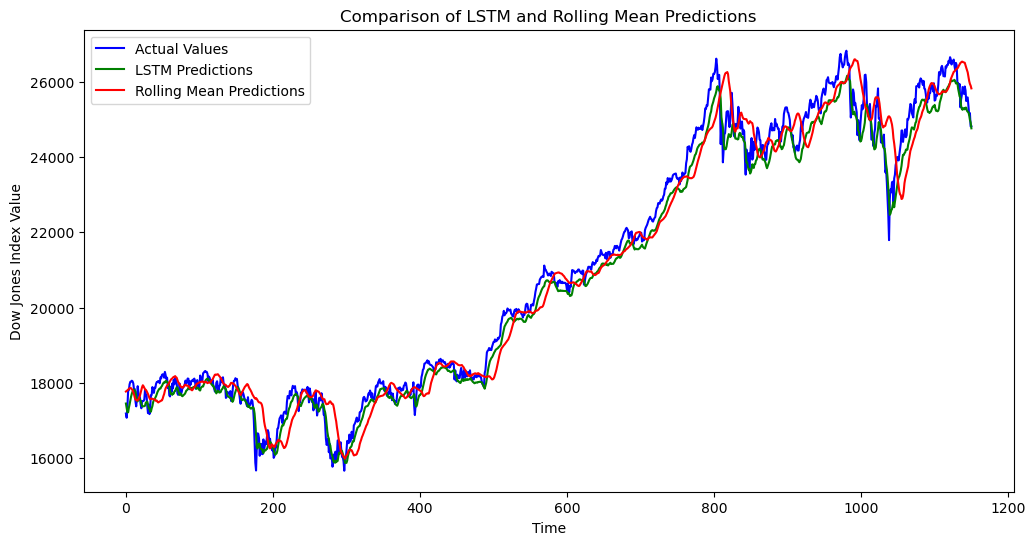

In [97]:
# Plotting
plt.figure(figsize=(12,6))
plt.plot(val_actuals_inverse[window_size:], label='Actual Values', color='blue')
plt.plot(val_predictions_inverse[window_size:], label='LSTM Predictions', color='green')
plt.plot(rolling_predictions, label='Rolling Mean Predictions', color='red')
plt.title('Comparison of LSTM and Rolling Mean Predictions')
plt.xlabel('Time')
plt.ylabel('Dow Jones Index Value')
plt.legend()
plt.show()


In [98]:
rolling_mse = mean_squared_error(val_actuals_inverse[window_size:], rolling_predictions)
print(f"Rolling Mean Model Validation MSE: {rolling_mse:.4f}")

model_mse = mean_squared_error(val_actuals_inverse, val_predictions_inverse)
print(f"LSTM Model Validation MSE: {model_mse:.4f}")


# Calculate changes (up/down) for rolling mean predictions
rolling_predicted_changes = np.diff(rolling_predictions) >= 0

# Calculate changes for actual values (aligned with rolling predictions)
rolling_actual_changes = np.diff(val_actuals_inverse[window_size:].flatten()) >= 0

# Calculate directional accuracy
rolling_correct_direction = rolling_actual_changes == rolling_predicted_changes
rolling_directional_accuracy = np.mean(rolling_correct_direction) * 100

print(f"Rolling Mean Model Directional Accuracy: {rolling_directional_accuracy:.2f}%")
print(f"LSTM Directional Accuracy: {np.sum(correct_direction)/len(correct_direction) * 100:.2f}%")


Rolling Mean Model Validation MSE: 369057.5854
LSTM Model Validation MSE: 149390.4219
Rolling Mean Model Directional Accuracy: 52.70%
LSTM Directional Accuracy: 51.72%


Rolling Mean Model Validation MSE: 369057.5854
Rolling Mean Model Directional Accuracy: 52.70%

LSTM, 10 epochs, 5 context, 41301 parameters
LSTM Model Validation MSE: 433850.3750
LSTM Directional Accuracy: 52.16%